# Trabalho 01 - Movimento de Corpo Rígido e Projeção Perspectiva

Feito por Arthur Lorencini e Fernanda Oliveira

## Descrição do Trabalho

Nesse primeiro trabalho deverá ser feito um programa onde será possível:

- Visualizar a posição e orientação tridimensional de uma câmera e de um objeto.

- Alterar a posição e orientação da câmera (parâmetros extrínsecos) através de translações e rotações tridimensionais (O objeto não precisa ser movimentado, apenas a câmera).

- As translações e rotações poderão ser feitas tanto em relação ao referencial do mundo quanto em relação ao referencial próprio da câmera.

- Visualizar a imagem do objeto gerada pela câmera.

- Alterar os parâmetros intrínsecos da câmera (distância focal, fator de escala de cada eixo, ponto principal)

- Toda vez que algo for alterado, a visualização 3D e a imagem gerada pela câmera deverão ser atualizadas.



## Importação das bibliotecas principais

In [1]:
# Importando as bibliotecas principais
!pip install numpy-stl
import os
import sys
from math import pi,cos,sin
import numpy as np
import matplotlib.pyplot as plt
from stl import mesh
from mpl_toolkits.mplot3d import Axes3D, art3d  
from operator import matmul
import matplotlib.ticker as ticker


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importação do Objeto STL

Código auxiliar fornecido pela professora do arquivo: read_stl3dModel.ipynb

# Criação do Objeto

In [2]:
cow = np.array([[0, 0, 0],
        [1, 0, 0],
        [1, 0, 2],
        [5, 0, 2],
        [5, 0, 0],
        [6, 0, 0],
        [6, 1, 0],
        [6, 1, 2],
        [6, 3, 2],
        [6, 3, 0],
        [6, 4, 0],
        [6, 4, 6],
        [6, 3, 6],
        [6, 3, 7],
        [8, 3, 7],
        [8, 3, 5],
        [6, 3, 5],
        [6, 3, 7],
        [6, 1, 7],
        [6, 1, 5],
        [6, 3, 5],
        [8, 3, 5],
        [8, 1, 5],
        [8, 1, 7],
        [8, 3, 7],
        [8, 1, 7],
        [6, 1, 7],
        [6, 1, 5],
        [8, 1, 5],
        [6, 1, 5],
        [6, 1, 6],
        [6, 0, 6],
        [6, 0, 0],
        [5, 0, 0],
        [5, 1, 0],
        [5, 1, 2],
        [5, 1, 0],
        [6, 1, 0],
        [5, 1, 0],
        [5, 1, 2],
        [5, 3, 2],
        [5, 3, 0],
        [6, 3, 0],
        [6, 4, 0],
        [5, 4, 0],
        [5, 4, 2],
        [5, 4, 0],
        [5, 3, 0],
        [5, 4, 0],
        [5, 4, 2],
        [1, 4, 2],
        [1, 4, 0],
        [0, 4, 0],
        [0, 4, 6],
        [6, 4, 6],
        [0, 4, 6],
        [0, 0, 6],
        [6, 0, 6],
        [0, 0, 6],
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 2],
        [5, 1, 2],
        [1, 1, 2],
        [1, 1, 0],
        [0, 1, 0],
        [0, 1, 2],
        [0, 3, 2],
        [0, 3, 0],
        [0, 4, 0],
        [0, 3, 0],
        [1, 3, 0],
        [1, 4, 0],
        [1, 3, 0],
        [1, 3, 2],
        [5, 3, 2],
        [1, 3, 2],
        [1, 1, 2]])

cow = np.transpose(cow)

#add a vector of ones to the box matrix to represent the box in homogeneous coordinates
cow = np.vstack([cow, np.ones(np.size(cow,1))])



In [3]:
### Setting printing options 
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.set_printoptions(precision=3,suppress=True)  

## Transformações e Funções

In [4]:
#Translação
def translation(dx,dy,dz):
    t = np.array([dx,dy,dz,1])
    T = np.eye(4)
    T[:,-1]=t.T
    return T

#Rotação
def z_rotation(angle):
    angle = angle * pi/180
    rotation_matrix=np.array([[cos(angle),-sin(angle),0,0],
                              [sin(angle),cos(angle),0,0],
                              [0,0,1,0],
                              [0,0,0,1]])
    return rotation_matrix

def x_rotation(angle):
    angle = angle * pi/180
    rotation_matrix=np.array([[1,0,0,0],
                              [0, cos(angle),-sin(angle),0],
                              [0, sin(angle), cos(angle),0],
                              [0,0,0,1]])
    return rotation_matrix

def y_rotation(angle):
    angle = angle * pi/180
    rotation_matrix=np.array([[cos(angle),0, sin(angle),0],
                              [0,1,0,0],
                              [-sin(angle), 0, cos(angle),0],
                              [0,0,0,1]])
    return rotation_matrix

#Mudança de Referencial
def change_cam2world (M,point_cam):
      p_world = np.dot(M,point_cam)
      return p_world

def change_world2cam (M,point_world):
      M_inv = np.linalg.inv(M)
      p_cam = np.dot(M_inv,point_world)
      return p_cam


# Função Auxiliar (3d Plot)
def set_axes_equal(ax):    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# Definição da câmera

In [5]:
#adding quivers to the plot
def draw_arrows(point,base,axis,length=0.5):
    # The object base is a matrix, where each column represents the vector 
    # of one of the axis, written in homogeneous coordinates (ax,ay,az,0)
    # Plot vector of x-axis
    axis.quiver(point[0],point[1],point[2],base[0,0],base[1,0],base[2,0],color='red',pivot='tail',  length=length)
    # Plot vector of y-axis
    axis.quiver(point[0],point[1],point[2],base[0,1],base[1,1],base[2,1],color='green',pivot='tail',  length=length)
    # Plot vector of z-axis
    axis.quiver(point[0],point[1],point[2],base[0,2],base[1,2],base[2,2],color='blue',pivot='tail',  length=length)

    return axis 

In [6]:
# base vector values
e1 = np.array([[1],[0],[0],[0]]) # X
e2 = np.array([[0],[1],[0],[0]]) # Y
e3 = np.array([[0],[0],[1],[0]]) # Z
base = np.hstack((e1,e2,e3))

#origin point
point = np.array([[0],[0],[0],[1]])

# You can also consider the camera as an object composed by its base and origin
# Then you can transform such object whenever you want to rotate or translate the camera 
cam  = np.hstack([base,point])


In [7]:
# Definição das condições iniciais da câmera
position = translation(10,4,2)
position0 = translation(0,0,0)

Rx = x_rotation(-90)
Rx0 = x_rotation(0)
Ry = y_rotation(0)
Ry0 = y_rotation(0)
Rz = z_rotation(90)
Rz0 = z_rotation(0)


cam0 = np.dot(position0, np.dot(Rz0,np.dot(Ry0,np.dot(Rx0, cam))))
new_cam_anterior = cam0

new_cam = np.dot(position, np.dot(Rz,np.dot(Ry,np.dot(Rx,cam))))
print(new_cam)



[[ 0. -0. -1. 10.]
 [ 1.  0.  0.  4.]
 [ 0. -1.  0.  2.]
 [ 0.  0.  0.  1.]]


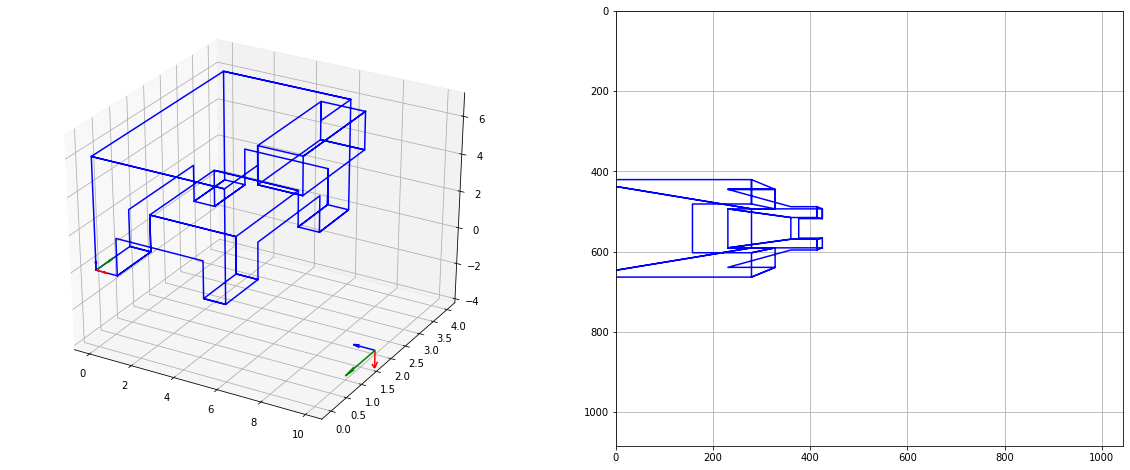

In [8]:
#@title Parâmetros de Entrada { run: "auto" }

#@markdown Parâmetros Extrínsecos
#@markdown   
#@markdown Transformações no Referencial da Câmera 
Rotation_x_cam = 0 #@param {type:"slider", min:-360, max:360, step:1}
Rotation_y_cam = 0 #@param {type:"slider", min:-360, max:360, step:1}
Rotation_z_cam = 0 #@param {type:"slider", min:-360, max:360, step:1}
Translation_x_cam = 0 #@param {type:"slider", min:-200, max:200, step:1}
Translation_y_cam = 0 #@param {type:"slider", min:-200, max:200, step:1}
Translation_z_cam = 0 #@param {type:"slider", min:-200, max:200, step:1}

#@markdown   
#@markdown Transformações no Referencial do Mundo 

Rotation_x_world = 0 #@param {type:"slider", min:-360, max:360, step:1}
Rotation_y_world = 0 #@param {type:"slider", min:-360, max:360, step:1}
Rotation_z_world = 0 #@param {type:"slider", min:-360, max:360, step:1}
Translation_x_world = 0 #@param {type:"slider", min:-200, max:200, step:1}
Translation_y_world = 0 #@param {type:"slider", min:-200, max:200, step:1}
Translation_z_world = 0 #@param {type:"slider", min:-200, max:200, step:1}

#@markdown Parâmetros Intrínsecos
f = 1 #@param {type:"slider", min:1, max:100, step:1}
sx = 243 #@param {type:"slider", min:0, max:1000, step:1}
sy = 243 #@param {type:"slider", min:0, max:1000, step:1}
ox = 522 #@param {type:"slider", min:0, max:1000, step:1}
oy = 542 #@param {type:"slider", min:0, max:1000, step:1}



# Transformações da câmera no referencial do mundo
# Essa parte é atualizada quando o usuário muda os parâmetros.
Translation_world = translation(Translation_x_world, Translation_y_world, Translation_z_world)
Rx_world = x_rotation(-90)
Ry_world = y_rotation(0)
Rz_world = z_rotation(0)

# Nova câmera com as transformações feitas
new_cam_ = np.dot(Translation_world, np.dot(Rz_world, np.dot(Ry_world, np.dot(Rx_world, np.dot(new_cam_anterior, new_cam)))))

# Transformações da câmera no referencial da câmera
Translation_cam = translation(Translation_x_cam,Translation_y_cam, Translation_z_cam)
Rx_cam = x_rotation(Rotation_x_cam)
Ry_cam = y_rotation(Rotation_y_cam)
Rz_cam = z_rotation(Rotation_z_cam)

M_inv = np.linalg.inv(new_cam_)
cam_orig = np.dot(M_inv,new_cam_)

new_cam_plot = np.dot(Translation_cam, cam_orig)
new_cam_plot = np.dot(Rz_cam, new_cam_plot)
new_cam_plot = np.dot(Ry_cam, new_cam_plot)
new_cam_plot = np.dot(Rx_cam, new_cam_plot)
new_cam_plot = np.dot(new_cam_,new_cam_plot)

#Transformações acumuladas
new_cam_anterior = new_cam_plot 
new_cam = cam0
#print(new_cam_plot)

# Camera Pinhole
#def camera_matrix(f_cam, sx_cam, sy_cam, ox_cam,oy_cam,skew):
#    return np.dot(
#        np.array([[f_cam*sx_cam,f_cam*skew, ox_cam],[0., f_cam*sy_cam, oy_cam],[0.,0.,1.]]), 
#        np.array([[1.,0.,0.,0.],[0.,1.,0.,0.],[0.,0.,1.,0.]]))

#matrix_intrinsec = camera_matrix(f, sx, sy, ox, oy, 0)

matrix_intrinsec = np.array([[f*sx,0, ox],[0, f*sy, oy],[0,0,1]])
matrix_canonic = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])


# Pontos 2d da imagem
object_ = change_world2cam(new_cam_plot,cow)
points_2d = np.dot(matrix_intrinsec,np.dot(matrix_canonic,object_))

#shape_2d = np.shape(points_2d)
#print(shape_2d)
#for k in range(0,shape_2d[1]):
# points_2d[0,k] = points_2d[0,k]/points_2d[2,k]
# points_2d[1,k] = points_2d[1,k]/points_2d[2,k]
# points_2d[2,k] = points_2d[2,k]/points_2d[2,k]

points_2d[0] = points_2d[0]/points_2d[2]
points_2d[1] = points_2d[1]/points_2d[2]
points_2d[2] = points_2d[2]/points_2d[2]


#########################
# Printando as figuras 

# Plot 3D
# Object
fig_width, fig_height = 20,8
fig = plt.figure(figsize=[fig_width, fig_height])
axes1 = fig.add_subplot(1,2,1, projection='3d')
#axes1 = plt.axes(projection='3d')
axes1.plot3D(cow[0,:], cow[1,:], cow[2,:], 'blue')
#axes1.add_collection3d(art3d.Poly3DCollection(object_vectors))
#axes1.add_collection3d(art3d.Line3DCollection(object_vectors, colors='k', linewidths=0.2, linestyles='-'))
#axes1.plot(object_stl[0,:],object_stl[1,:],object_stl[2,:],'k.')
#axes1.auto_scale_xyz(new_cam_plot[0,:],new_cam_plot[1,:],new_cam_plot[2,:])
#set_axes_equal(axes1)
#axes1.view_init(elev=45,azim=-35)
#axes1.dist=10

# Camera
draw_arrows(point,base,axes1)
axes1 = draw_arrows(new_cam_plot[:,3],new_cam_plot[:,0:3],axes1,length=1)
#set_axes_equal(axes1)

# Plot 2D
axes2 = fig.add_subplot(1,2,2)
axes2.set_xlim([0,ox*2])
axes2.set_ylim([0,oy*2])
axes2.plot(points_2d[0,:],points_2d[1,:],'blue')
axes2.invert_yaxis()
axes2.grid()

plt.show()
